# ASHRAE - Great Energy Predictor III
#### This project is based on a Kaggle competition with data provided by ASHRAE (American Society of Heating and Air-Conditioning Engineers). 

Exploratory Data Analysis (EDA) aims to understand the nature of all present variables (continuous and discrete) through the use of statistical plots, descriptive and inferential statistics. This exploration will help locate missing values, outliers, patterns and relationships between variables. Ideally, the knowledge gained in this section will be leveraged to build a machine learning model that minimizes prediction error. 

This project aims to answer the following questions:
* Identify buildings which use more energy than most others.
* Which type of buildings consume the most energy?
* Which form of energy is consumed the most? 
* Predict energy usage `meter_reading`.


Note: some conversion is required.
```
"Due to a miscommunication, the electric meter readings for site 0 were not properly converted to units of kWh and are in kBTU. We apologize for the error and the resulting inconvenience.

The units of the electric meter readings for site 0 will not be updated (i.e., they will remain as is), since this could potentially disrupt the workflows and models of many teams. For models that are sensitive to units/absolute values, the issue can be avoided with the right conversion factors. Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring."
```

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.graph_objects as go

from datetime import datetime
from dateutil import parser

# format float in pandas
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

In [2]:
plt.style.use('seaborn-white')
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.xmargin'] = 0.02
rcParams['axes.ymargin'] = 0.02
            
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.alpha'] = 0.2
rcParams['grid.color'] = 'black'
          
rcParams['figure.titlesize'] = 'x-large'
rcParams['figure.edgecolor']= 'black'
rcParams['figure.facecolor'] = 'white'
rcParams['figure.figsize'] = [12, 8]

rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

In [3]:
# Load data
train_df = pd.read_csv('../data/train.csv')
# test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_metadata.csv')
weather_df = pd.read_csv('../data/weather_train.csv')
# weather_test_df = pd.read_csv('../data/weather_test.csv')


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [6]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [7]:
# CHECK DUPLICATES
building_df.duplicated(subset='building_id').any()

False

In [8]:
def nan_val_summary(df):
    """Summarize the counts of missing values"""
    nan_arr = np.count_nonzero(df.isnull(), axis=0)
    frac = nan_arr / df.shape[0]
    nan_df = pd.DataFrame(
        {'columns': df.columns,
         'nan_count': nan_arr,
         'fraction_missing': frac}
                 )
    return nan_df

def to_category(df, cols):
    """
    Iterates over `cols` and convert specified columns' 
    dtype to `category`.
    
    Params:
    --------
        cols: list of strings
              Name of columns from a DataFrame
    Returns:
    --------
        None
    
    """
    for item in cols:
        df[item] = df[item].astype('category')
        
def convert_dtype(df):
    """
    Convert data type of each column to reduce memory usage.
    """
    cols = df.columns.values
    data_types = ('int', 'float')
    
    # iterate over each column
    for col in cols:
        # convert integers
        if data_types[0] in str(df[col].dtype):
            df[col] = df[col].astype(np.int32)
        if data_types[1] in str(df[col].dtype):
            df[col] = df[col].astype(np.float32)
    return df

# Datetime Conversion

In [9]:
dt_format = "%Y-%m-%d %H:%M:%S"
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format=dt_format)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format=dt_format)

# Visuals: Buildings Data
Let's explore the types of buildings that are present in this data set.

In [10]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0000,nan
1,0,1,Education,2720,2004.0000,nan
2,0,2,Education,5376,1991.0000,nan
3,0,3,Education,23685,2002.0000,nan
4,0,4,Education,116607,1975.0000,nan


In [11]:
building_df['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In [12]:
def plot_bar(x, y, title='', x_axis='', y_axis='', **kwargs):
    """
    Plotly Bar graph.
    """
    fig = go.Figure(
        data=[go.Bar(x=x,
                     y=y)]
    )
    # update title and axis
    fig.update_layout(
        title_text = title,
        xaxis_title_text = x_axis,
        yaxis_title_text = y_axis,
        bargap=0.05,
        **kwargs
    )
    return fig.show()


# barplot settings
# barplot_settings = {'width': 1,
#                     'edgecolor': 'k',
#                     'color': color[2]
#                    }

# matplotlib bar plot
def bar_plot(x, y, title='', x_label='', y_label='', fig_size=(16, 8), **kwargs):
    """Simple bar plot using Seaborn"""
    
    plt.figure(figsize=fig_size)
    sns.barplot(x=x,
                y=y,
                color=color_pal[0],
                **kwargs
               )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

def barh_plot(y, x, title='', x_label='', y_label='', fig_size=(16, 8), **kwargs):
    """Horizontal simple bar plot"""

    plt.figure(figsize=fig_size)
    plt.barh(y, x, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

def scatter_plot(x, y, title='', x_label='', y_label='', **kwargs):
    """Seaborn scatter plot"""
    sns.scatterplot(x, y, **kwargs)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    
    

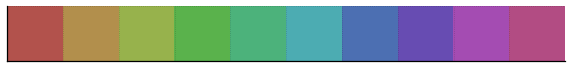

In [13]:
# color palette
color_pal = sns.hls_palette(10, l=.5, s=.4)
sns.palplot(color_pal)


## Building Type

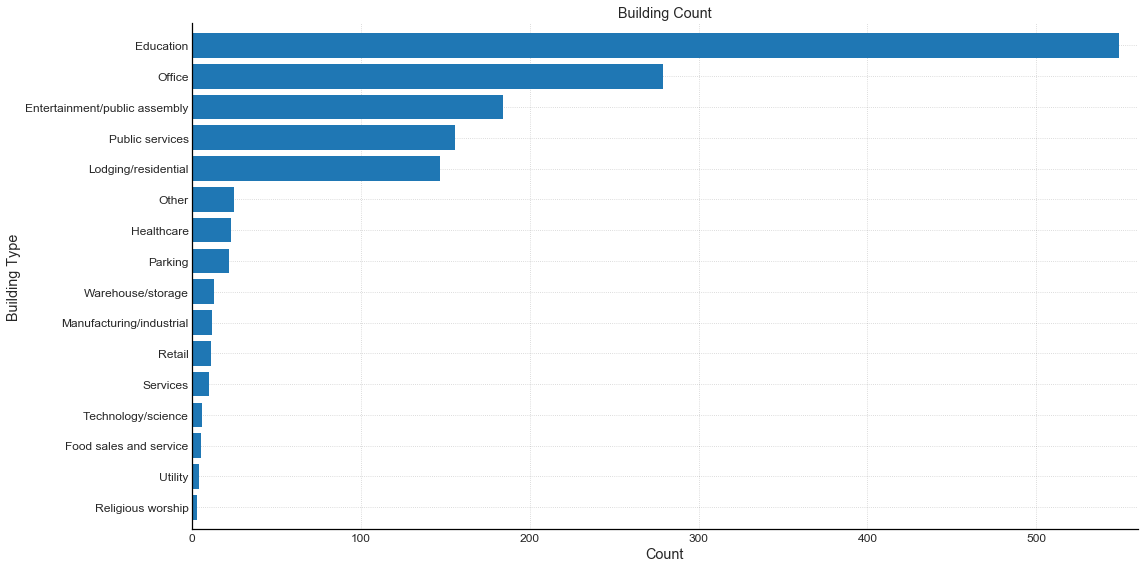

In [14]:
# extract building type into x and y
x_use = building_df['primary_use'].value_counts().sort_values().index.values
y_count = building_df['primary_use'].value_counts().sort_values().values

barh_plot(x_use,
          y_count,
         title='Building Count',
         y_label='Building Type',
         x_label='Count')

plt.show()

### Building Area (Ft$^2$)
Visualizing the distribution of the building's area we can see that it resembles an exponential distribution. The median area is about $57,673$ square feet which implies that 50% of the buildings in this data set are less than $57,673$ ft$^2$. 

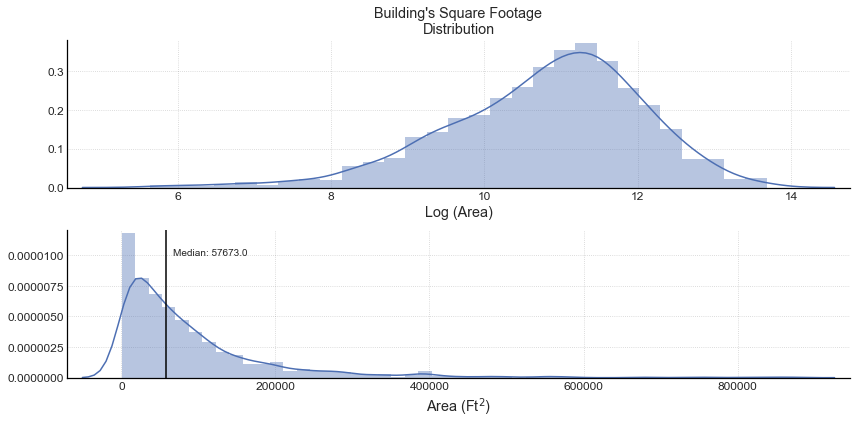

In [15]:
# BUILDING AREA (SQ. FT.) DISTRIBUTION
plt.subplots(1,2, figsize=(12, 6))

# compute (natural) log of area
sq_ft_log = np.log(building_df.square_feet.values)
# compute median to plot vertical line
sq_ft_median = np.median(building_df.square_feet.values)
# set color value
c=color_pal[6]

# Plot KDE Log of Area
plt.subplot(211)
sns.distplot(sq_ft_log, color=c)
plt.xlabel('Log (Area)')
plt.title("Building's Square Footage\nDistribution")

# Plot KDE Area
plt.subplot(212)
sns.distplot(building_df.square_feet.values, color=c)
plt.xlabel('Area (Ft$^2$)')
# plot median value, and annotate
plt.axvline(x=sq_ft_median, color='k')
plt.text(x=sq_ft_median+10000, s=f'Median: {sq_ft_median}', y=0.000010)

plt.tight_layout()
plt.show()

## Construction
Visualizing construction date.

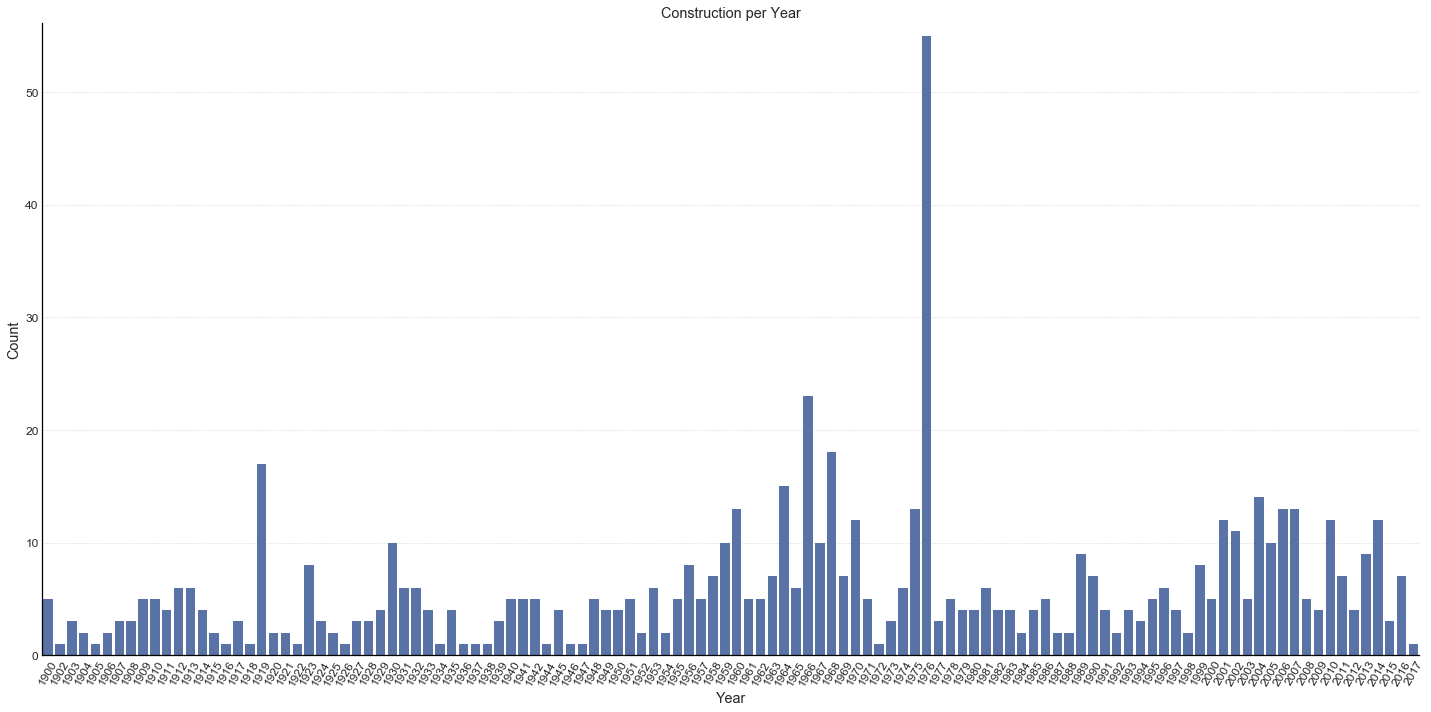

In [16]:
# CONSTRUCTION PER YEAR
x = np.uint32(building_df['year_built'].value_counts().index.values)

# plt.show()
plt.figure(figsize=(20, 10))
sns.barplot(x=x,
            y=building_df['year_built'].value_counts().values,
            color=c,
           )
plt.xticks(rotation=60)
plt.xlabel('Year')
plt.title('Construction per Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [17]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0000,nan
1,0,1,Education,2720,2004.0000,nan
2,0,2,Education,5376,1991.0000,nan
3,0,3,Education,23685,2002.0000,nan
4,0,4,Education,116607,1975.0000,nan


## Building Type and Area

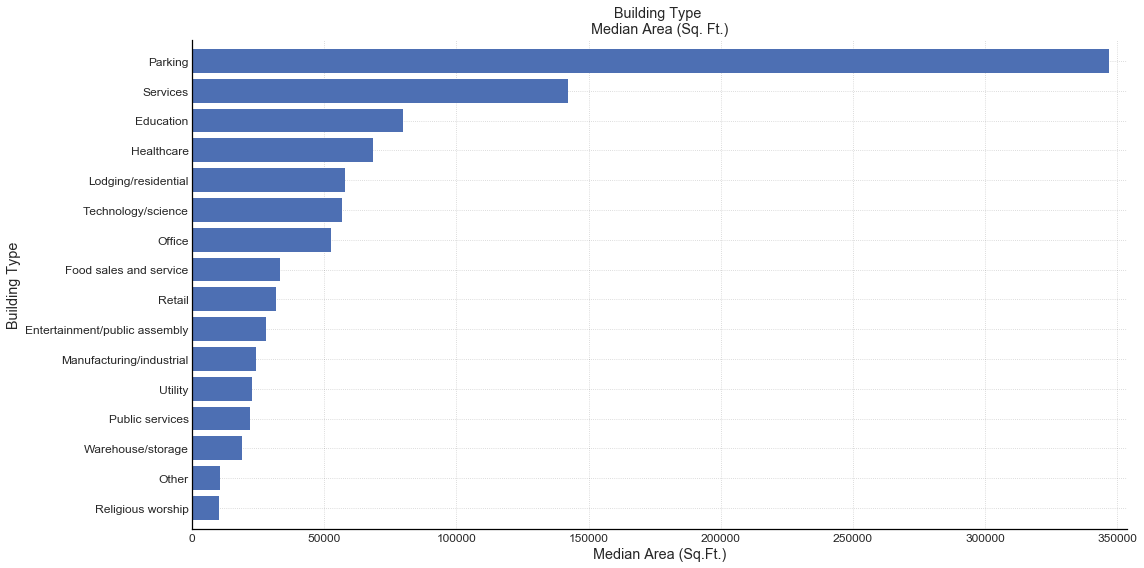

In [18]:
bldg_use_area = building_df.groupby(['primary_use'])['square_feet'].median()
x=bldg_use_area.sort_values().index.tolist()
y=bldg_use_area.sort_values()

# horizontal barplot
barh_plot(x, 
          y, 
          title='Building Type \nMedian Area (Sq. Ft.)',
          x_label='Median Area (Sq.Ft.)',
          y_label='Building Type',
          color=c
         )
plt.show()


## Weather 

In [19]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [20]:
weather_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.0000,139718.0000,70600.0000,139660.0000,89484.0000,129155.0000,133505.0000,139469.0000
mean,7.4790,14.4181,2.1493,7.3502,0.9830,1016.1580,180.5266,3.5605
std,4.6047,10.6266,2.5991,9.7902,8.4637,7.6297,111.5236,2.3359
min,0.0000,-28.9000,0.0000,-35.0000,-1.0000,968.2000,0.0000,0.0000
25%,3.0000,7.2000,0.0000,0.6000,0.0000,1011.8000,80.0000,2.1000
50%,7.0000,15.0000,2.0000,8.3000,0.0000,1016.4000,190.0000,3.1000
75%,11.0000,22.2000,4.0000,14.4000,0.0000,1020.8000,280.0000,5.0000
max,15.0000,47.2000,9.0000,26.1000,343.0000,1045.5000,360.0000,19.0000


## Missing Values: Weather Data
Missing values in the weather data set will be filled based on location and time. To accomplish this, data is grouped on three variables, `site_id`, `month`, and `day`. Then, given a variable for which to fill missing values, a statistic is calculated (median). For example, to fill the `air_temperature` missing values, after data is grouped, the median temperature is calculated for the specific location, month and day. This should specific grouping should provide an accurate method for filling missing values in all variables contained within the weather data set.

In [21]:
def get_nan_idx(column, df=weather_df):
    """
    Returns the indices of missing values in given 
    column and DataFrame.
    """
    return df[df[column].isna()].index.values 

def get_nan_columns(df):
    """
    Extract name of columns which have missing values.
    """
    df = nan_val_summary(df)
    return df[df['fraction_missing'] > 0]['columns'].values


In [22]:
def fill_weather_nans(column, df=weather_df, agg_func='median'):
    """
    Fills in missing values in Weather data. Column name must be provided.
    Function fills missing values inplace and therefore returns nothing.
    
    Uses the following method to fill NaNs:
        1. Groupby three variables, `site_id`, `month`, and `day`
        2. Compute `agg_func`, this will be used to fill missing values
        3. Check for missing values in aggregated data
            - If missing values present
                - Use interpolation to fill those missing values
        4. Set index of DataFrame `df`  such that it matches the aggregated 
        DataFrame index
        5. Update DataFrame `df` and fill missing values
        6. Reset index of `df`
    
    Params:
    -------
        column: str
            Name of column to fill
            
    Returns:
    --------
        None
        DataFrame is updated inplace.
    """
    
    # new features: month, hour
    df['month'] = weather_df['timestamp'].dt.month
    df['hour'] = weather_df['timestamp'].dt.hour
    df['day'] = weather_df['timestamp'].dt.day
    
    # aggregate data to obtain median value for a particular site, month, and day
    agg_weather_df = pd.DataFrame(df.groupby(['site_id', 'month', 'day'])[column].agg(agg_func))
    
    # check for missing values in the aggregated data
    if agg_weather_df[column].isnull().any():
        # fill NaNs using interpolation
        agg_df = agg_weather_df[column].interpolate(limit_direction='both',
                                                    inplace=True)
        agg_weather_df.update(agg_df, overwrite=False)
        
    # set index before updating input DataFrame
    df.set_index(['site_id', 'month', 'day'], inplace=True)
    df.update(agg_weather_df, overwrite=False)
    
    # reset index
    df.reset_index(inplace=True)

In [23]:
nan_val_summary(weather_df)

,columns,nan_count,fraction_missing
0,site_id,0,0.0000
1,timestamp,0,0.0000
2,air_temperature,55,0.0004
3,cloud_coverage,69173,0.4949
4,dew_temperature,113,0.0008
5,precip_depth_1_hr,50289,0.3598
6,sea_level_pressure,10618,0.0760
7,wind_direction,6268,0.0448
8,wind_speed,304,0.0022


In [24]:
# new features: month, hour
weather_df['month'] = weather_df['timestamp'].dt.month
weather_df['hour'] = weather_df['timestamp'].dt.hour


In [25]:
nan_cols = get_nan_columns(weather_df)
[fill_weather_nans(col) for col in nan_cols]

[None, None, None, None, None, None, None]

In [26]:
nan_val_summary(weather_df)

,columns,nan_count,fraction_missing
0,site_id,0,0.0000
1,month,0,0.0000
2,day,0,0.0000
3,timestamp,0,0.0000
4,air_temperature,0,0.0000
5,cloud_coverage,0,0.0000
6,dew_temperature,0,0.0000
7,precip_depth_1_hr,0,0.0000
8,sea_level_pressure,0,0.0000
9,wind_direction,0,0.0000


## Meter

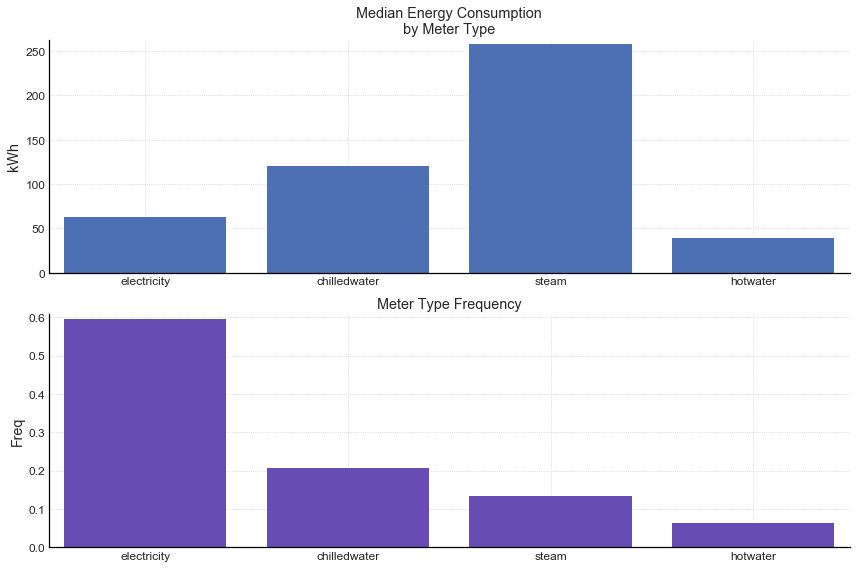

In [27]:
# PLOT: energy use and meter type count
energy_use = train_df.groupby(['meter'])['meter_reading'].median()
meter_count = train_df['meter'].value_counts() / train_df['meter'].shape[0]

labels = ('electricity', 'chilledwater', 'steam', 'hotwater')

plt.subplots(1,2, figsize=(12, 8))

# first subplot
plt.subplot(211)
bar1 = plt.bar(
    x=labels,
    height=energy_use.values,
    color=color_pal[6]
)
plt.title('Median Energy Consumption\nby Meter Type')
plt.ylabel('kWh')

# second subplot
plt.subplot(212)
bar2 = plt.bar(
    x=labels,
    height=meter_count.values,
    color=color_pal[7]
)
plt.title('Meter Type Frequency')
plt.ylabel('Freq')

plt.tight_layout()
plt.show()

## Merge 

In [28]:
tb_df = pd.merge(train_df, building_df, on='building_id')
all_df = pd.merge(tb_df, weather_df, on=['site_id', 'timestamp'])


In [29]:
all_df.shape

(20125605, 19)

In [30]:
def get_building_id(building_id, df=all_df):
    """
    Extract subset DataFrame for the given `building_id`.
    
    Returns: pandas DataFrame
    -------
        DataFrame
    """
    df_sub = df[df['building_id'] == building_id]
    return df_sub
    

def get_site(site_id, df=all_df):
    """
    Extract subset DataFrame for the given location (`site_id`)
    
    Returns: pandas DataFrame
    --------
        Subset DataFrame for the given `site_id`
    
    """
    if (site_id < 0) | (site_id > 15):
        print('Please enter valid `site_id`')
        print('Available sites:', all_df.site_id.unique())  
        return
        
    df = df[df['site_id'] == site_id]
    return df


def get_meter_subset(meter_id, df=all_df, site_id=None):
    """
    Subset DataFrame according to meter type, and optionally,
    by `site_id`.
    
    Returns pandas DataFrame.
    
    """
    if site_id != None:
        df = get_site(site_id)
    
    meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
    # select meter_id and variables, then set index to timestamp
    df = df[df['meter'] == meter_id].set_index('timestamp')
    
    return df
    
    
def plot_meter(meter_id, df=all_df, resample_values=('D', 'W'), plot_weekly=False, site_id=None):
    """
    Plot energy use of a specified meter type:
        `{0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}`
        
    Two plots are produced. Values are resampled at Daily and Weekly rate
    which are plotted along side. 
    Additionally, the location of the site may be specified. 
    
    Params:
    -------
        meter_id: int
            Type of meter (0, 1, 2, 3)
            
        df: pd.DataFrame
            DataFrame from which to pull `meter_id`
            
        resample_values: tuple, default=('D', 'W')
            Rates at which data is resampled. By default, it is resampled 
            at Daily and Weekly rate.
            Example: ('6H', 'D') First plot will be resampled at six hour
                     interval and second plot at Daily rate
        
    Returns:
    --------
        None
    """
    if site_id != None:
        df = get_site(site_id)
    
    meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
    # select meter_id and variables, then set index to timestamp
    df = df[df['meter'] == meter_id].set_index('timestamp')
    df = df[['meter_reading', 'air_temperature']]
    
    # resample 
    meter_type_df = df['meter_reading'].resample(resample_values[0]).mean()
    other_sample = df['meter_reading'].resample(resample_values[1]).mean()
    air_temp = df['air_temperature'].resample('D').mean()

    # make two plots
    # hourly sample and other (specified) resampled values
    try:
        # HOURLY PLOT
        meter_type_df.plot(kind='line', 
                           color=color_pal[6], 
                           label=f'{resample_values[0]} Avg.',
                           legend=True,
                           linewidth=2)
        # WEEKLY
        if plot_weekly:
            other_sample.plot(kind='line', 
                              color='k', 
                              label=f'{resample_values[1]} Avg.',
                              legend=True)
        # AIR TEMP
        air_temp.plot(kind='line', 
                      secondary_y=True, 
                      color='red', 
                      label='Air Temp. Daily Avg.',
                      alpha=0.6,
                      linewidth=0.8,
                      legend=True)
    
        # set title accordingly, if `site_id` param is provided
        title = f'{meter_dict[meter_id].capitalize()} Meter Reading\n'
        if site_id != None:
            title = f'{meter_dict[meter_id].capitalize()} Meter Reading\nSite {site_id}'
        # title, and axis labels
        plt.title(title)  
        plt.xlabel('Time')
        plt.ylabel('kWh')
        plt.tight_layout()
    except:
        print('Data not available for specified parameters')
        pass

def subplot(plot):
    """
    Make subplots for the four different types of meters.
    Param `plot` takes a function which produces a single plot
    of a given `meter_id`.
    
    """
    plt.subplots(2,2, figsize=(18, 10))
    sub_plots = [221, 222, 223, 224]
    meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
    # loop over subplots and meters
    for subplt, mtrs in zip(sub_plots, meter_dict.keys()):
        # subplot
        plt.subplot(subplt)
        # call plot function here
        plot(mtrs)

    plt.show()

In [31]:
# CONVERSION TO KWH
# convert site 0 to kWh
site_0_conversion = pd.DataFrame(get_site(0)['meter_reading'] * 0.2931)

# update the combined DataFrame with the converted units
all_df.update(site_0_conversion)


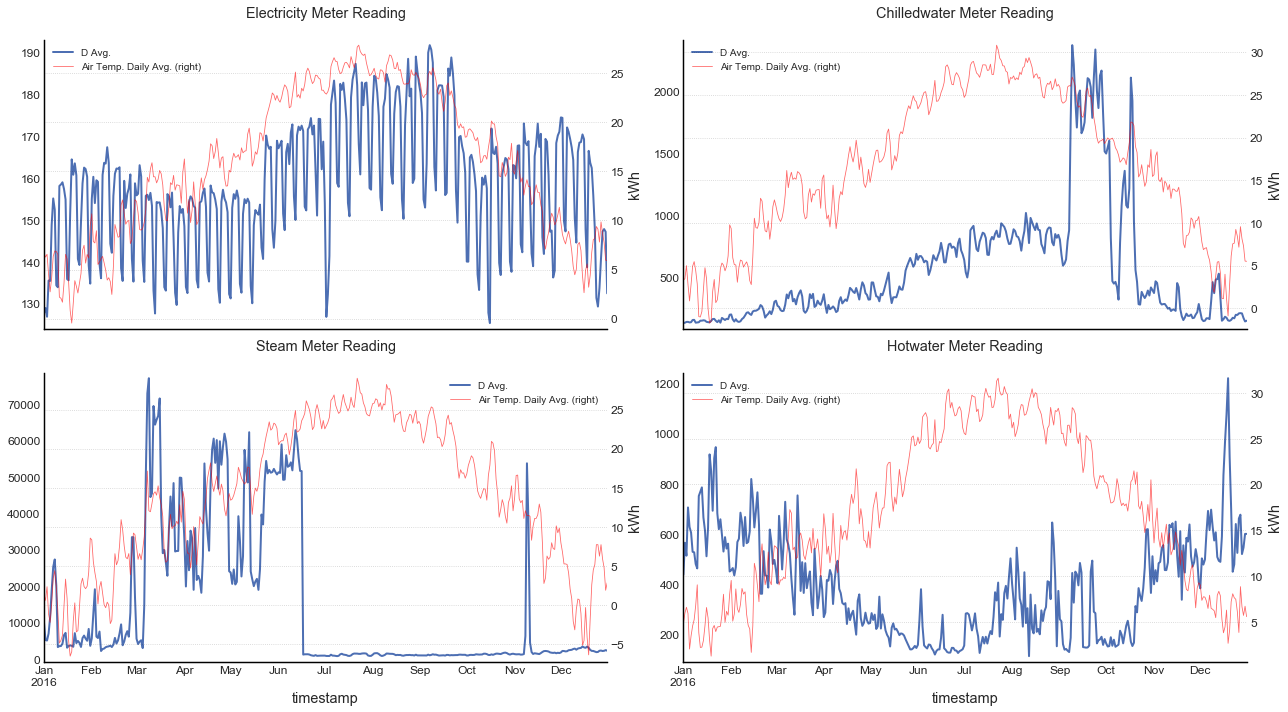

In [32]:
# PLOT: all four meters
subplot(plot_meter)

The above plots summarize the meter readings throughout the year across all buildings and sites/locations. For the most part, trends appear as expected. 
 * Electricity is being consumed at a higher rate during the summer months (for A/C) before declining going into the winter. 
 * Chilled water production also rises heading into the warmer months, but interestingly, it seems to peak in late September and October still has some high fluctuations as well. 
 * Steam is a bit odd. It seems to be consumed at a higher rate in the Spring months starting in March and going through May. However, this is only one year and temperatures may have been unsusually lower. 
 * Hot water shows an interesting trend between the months of August and October. It appears as though hot water consumption increases in August through September and then settles down for a month until November begins. 

In [33]:
all_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,month,day,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,2016-01-01,0.0000,0,Education,7432,2008.0000,nan,1,1,25.0000,6.0000,20.0000,0.0000,1019.7000,0.0000,0.0000,0
1,1,0,2016-01-01,0.0000,0,Education,2720,2004.0000,nan,1,1,25.0000,6.0000,20.0000,0.0000,1019.7000,0.0000,0.0000,0
2,2,0,2016-01-01,0.0000,0,Education,5376,1991.0000,nan,1,1,25.0000,6.0000,20.0000,0.0000,1019.7000,0.0000,0.0000,0
3,3,0,2016-01-01,0.0000,0,Education,23685,2002.0000,nan,1,1,25.0000,6.0000,20.0000,0.0000,1019.7000,0.0000,0.0000,0
4,4,0,2016-01-01,0.0000,0,Education,116607,1975.0000,nan,1,1,25.0000,6.0000,20.0000,0.0000,1019.7000,0.0000,0.0000,0


## Histogram: Meter Type

In [34]:
# get_meter_subset(1).head()

In [35]:
# for i in range(4):
#     print(get_meter_subset(i)['meter_reading'].describe())
#     print('\n')


In [36]:
def plot_distribution(meter_id, column='meter_reading'):
    """
    Plot distribution of `meter_reading` for a given meter type.
    """
    # get a subset of dataframe for given meter type
    m = get_meter_subset(meter_id)[column]
    # meter type dict
    meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
    # comptue bins
    n_bins = np.int32(np.sqrt(m.shape[0])/ 10) 
    # plot historgram with KDE
    sns.distplot(np.log1p(m.values), bins=n_bins)
    plt.xlabel(f'Log {column}')
    plt.ylabel('Frequency')
    plt.title(f'{meter_dict[meter_id].capitalize()}\nDistribution')
    plt.tight_layout()


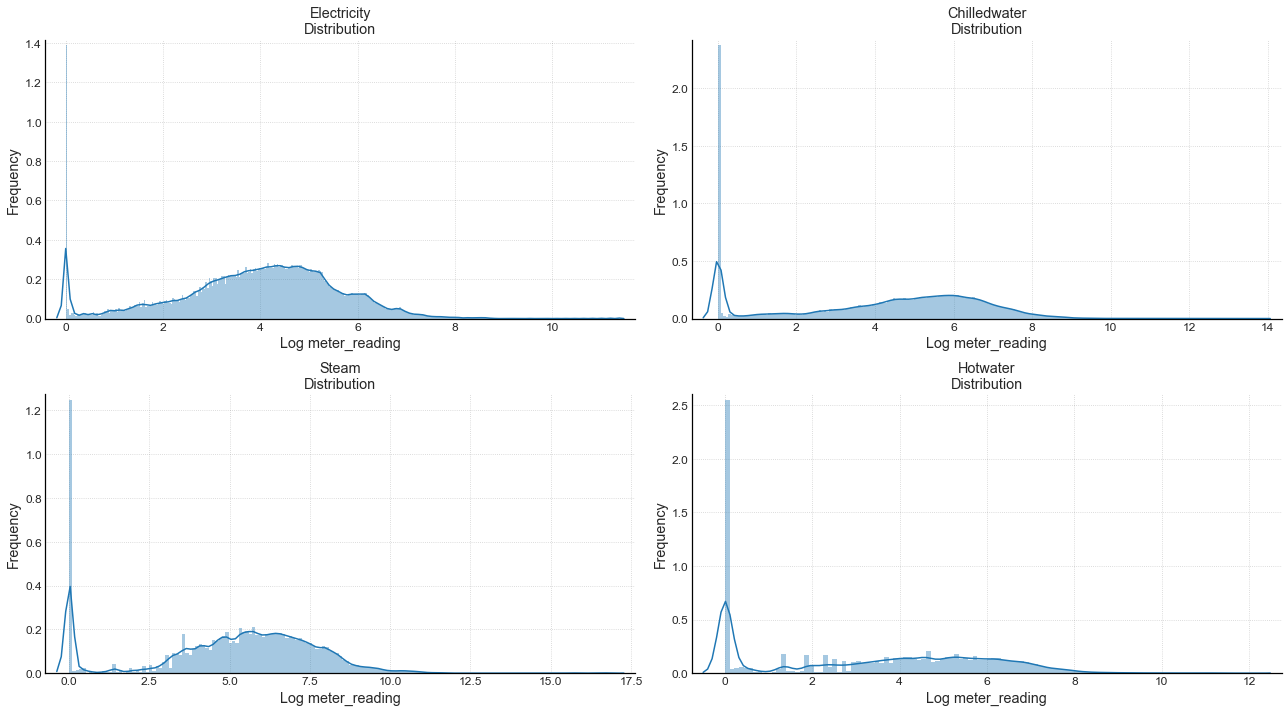

In [37]:
# distribution for all data
subplot(plot_distribution)

Distribution plots show an interesting anamoly. There appears to be a large count of zeros for each meter type. It would be unusual for an electric meter to read zero at any time. Other meters, hot/chilled water and steam, may be turned off during particular months so it's not unusual for meters to be zero. This will need to be explored further and the zeros may need to be removed before building a machine learning model. Additionally, there are some extremely large values present which skew the plots. These too may be anomalous readings which may have to be removed. 

In [38]:
# for i in range(4):
#     print(get_meter_subset(i)['meter_reading'].describe())
#     print('\n')

# Identify buildings which use the most energy

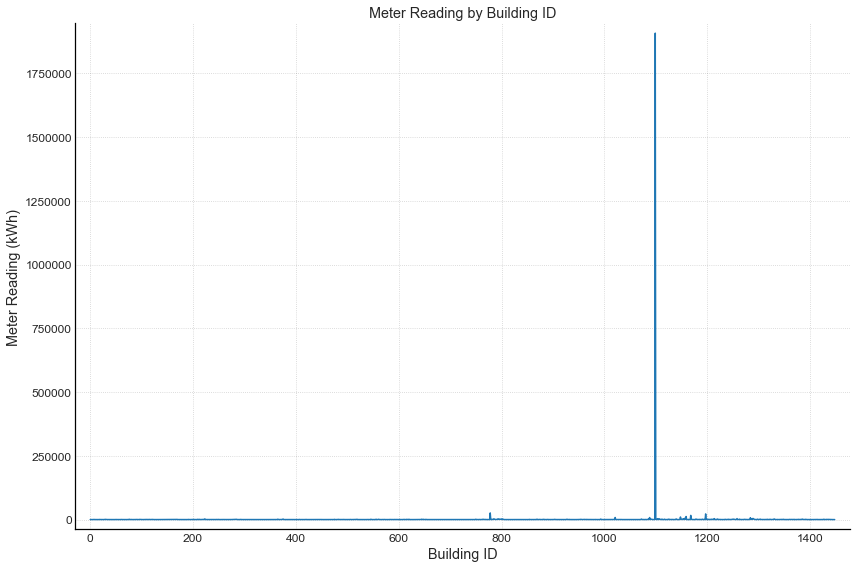

In [39]:
# PLOT: comparison of all buildings
plt.plot(all_df.groupby('building_id')['meter_reading'].mean().values)
plt.xlabel('Building ID')
plt.ylabel('Meter Reading (kWh)')
plt.title('Meter Reading by Building ID')
plt.tight_layout()
plt.show()

It seems something may have gone wrong with a meter reading at that one particular building. 

In [40]:
# find building id that's using up all the steam
mx = get_meter_subset(2)['meter_reading'].max()
get_meter_subset(2)[get_meter_subset(2)['meter_reading'] == mx].building_id.values

array([1099], dtype=int64)

In [41]:
bldg_1099 = all_df[all_df['building_id'] == 1099]

In [42]:
# bldg_1099[(bldg_1099['air_temperature'] > 5) & (bldg_1099['month'] > 7)].head()

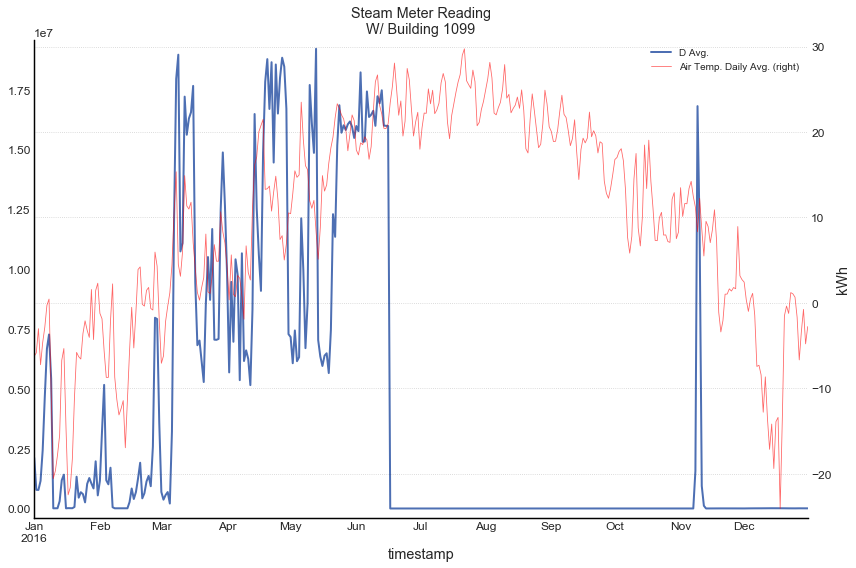

In [43]:
# PLOT: Building 1099
plot_meter(2, df=bldg_1099)
plt.title('Steam Meter Reading\nW/ Building 1099')
plt.show()

Building 1099 appears to have extremely high meter readings for steam through spring and early summer seasons. This building is adding noise to the data so it should be excluded so that our machine learning model will have a chance to learn the true signal.

In [44]:
# drop indices with building 1099

idx = np.where(all_df['building_id'] == 1099)[0]
# all_df.loc[idx]
df_no1099 = all_df.drop(idx, axis=0)

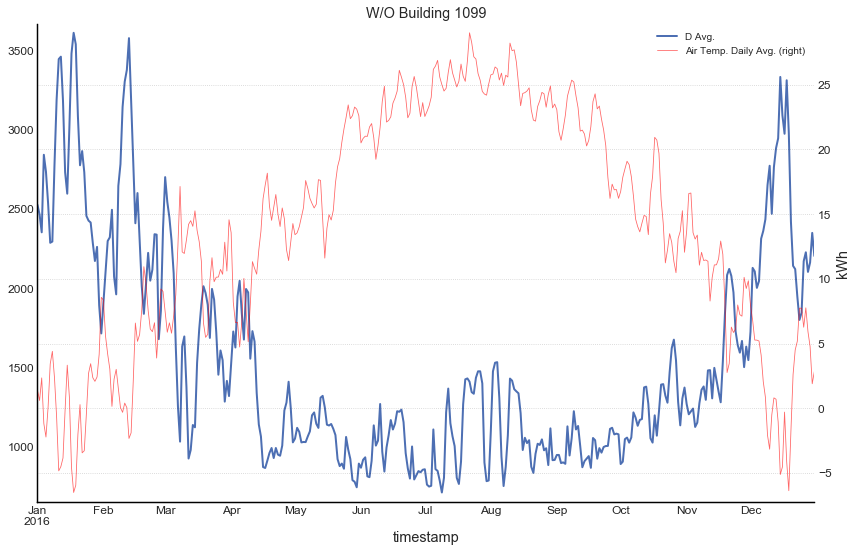

In [45]:
# PLOT: data without building 1099
plot_meter(2, df=df_no1099)
plt.title('W/O Building 1099')
plt.show()

In [74]:
df_agg = (df_no1099.groupby('building_id')['meter_reading'].mean().values)

array([ 42.92595412,  21.94304671,   4.26501089, ...,   3.60832287,
       187.70344139,   3.32936463])

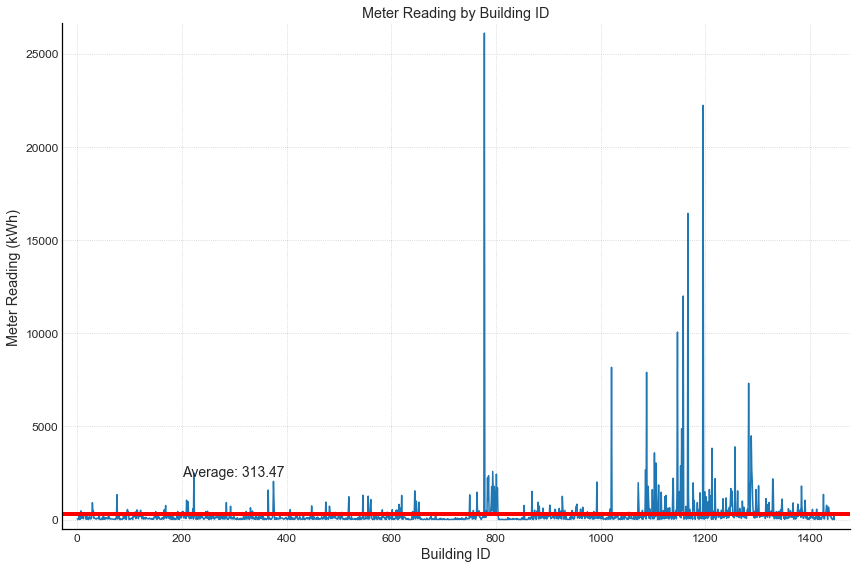

In [88]:
# PLOT: W/O Buuilding 1099
# TODO: plot log and without
df_agg = (df_no1099.groupby('building_id')['meter_reading'].mean().values)
mean_agg = np.round(np.mean(df_agg), 2)
plt.plot(df_agg)
plt.xlabel('Building ID')
plt.ylabel('Meter Reading (kWh)')
plt.title('Meter Reading by Building ID')
# average consumption line
plt.axhline(y=np.mean(df_agg), color='red', linewidth=4.0)
plt.text(x=200, s=f'Average: {mean_agg}', 
         y=mean_agg+2000, 
         fontdict={'size':14})
plt.tight_layout()
plt.show()

From the plot above, there are numerous other buildings which consume well above average amount of energy. 

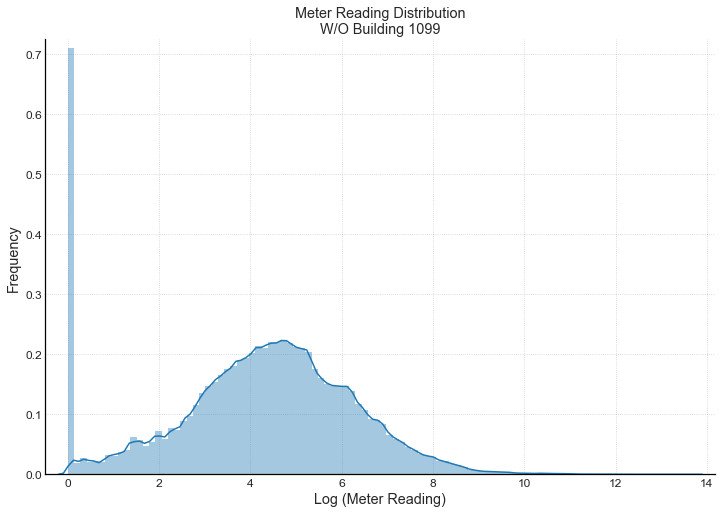

In [47]:
# PLOT: Distribution of meter reading w/o building 1099
mr = np.log1p(df_no1099['meter_reading'])

sns.distplot(mr, bins=100)
plt.title("Meter Reading Distribution\nW/O Building 1099")
plt.xlabel('Log (Meter Reading)')
plt.ylabel('Frequency')
plt.show()

In the above two plots, building 1099 has been removed from the DataFrame. However, even with building 1099 out of the way, there appears to be a handful of buildings consuming a tremendous amount of energy compared to others. The histogram's long tail to the right shows us that there are more outliers. 

In [62]:
# compute 99th quantile and filter DataFrame
q = all_df['meter_reading'].quantile(0.99)
q

5179.44

In [63]:
q = all_df['meter_reading'].quantile(0.99)
df_no1099[df_no1099['meter_reading'] > q].shape[0]

196492

There are another 196,492 buildings consuming more energy than 99% of all buildings in this training data. 

In [64]:
# find another building that consuming tremendous amount of energy
max_idx = np.where(df_no1099['meter_reading'] == df_no1099['meter_reading'].max())[0]
all_df.loc[max_idx, :]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,month,day,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
8508411,778,1,2016-09-09 17:00:00,880374.0000,6,Entertainment/public assembly,108339,nan,nan,9,9,33.9000,0.0000,20.0000,0.0000,1014.5000,200.0000,1.5000,17


In [51]:
get_building_id(778).groupby('meter')['meter_reading'].describe()

,count,mean,std,min,25%,50%,75%,max
meter,,,,,,,,
0,8773.0000,242.0831,75.0555,0.0000,166.6670,224.7500,315.5000,406.9500
1,8084.0000,54153.1466,163892.3473,0.0000,0.0000,0.0000,0.0000,880374.0000


In [52]:
df_no1099[df_no1099['meter_reading'] > 25000].building_id.unique()

array([  60,  778,  993,  954,  903,  927,  955,  879,  904,  934,  961,
        973, 1021, 1148, 1159, 1168, 1197, 1107, 1088, 1104, 1156, 1214,
       1154, 1140, 1072, 1284, 1258, 1331], dtype=int64)

In [70]:
# compute mean consumption by each building
bldg_mean = all_df.groupby('building_id')['meter_reading'].mean()
bldg_mean.sort_values()[-30:]

building_id
993       2014.9583
1291      2024.7470
375       2048.2109
1330      2182.7517
1220      2195.9170
1140      2223.0580
784       2241.1814
786       2354.0379
1158      2369.1658
801       2436.5601
223       2496.7005
794       2584.3264
1086      2669.1108
1290      2674.0965
1154      2888.0840
1107      3036.4376
1104      3579.1605
1214      3826.0350
1258      3900.0368
1289      4490.6738
1156      4875.3081
1284      7313.3569
1088      7900.8854
1021      8170.4809
1148     10058.4410
1159     11991.3309
1168     16424.8016
1197     22222.1673
778      26095.8553
1099   1907662.6094
Name: meter_reading, dtype: float64

In [67]:
q = np.log1p(all_df['meter_reading'].quantile(0.7))
q10 = all_df['meter_reading'].quantile(0.05)

meter_ = all_df['meter_reading'][(all_df['meter_reading'] < q) & (all_df['meter_reading'] > 1)]
df = all_df[(all_df['meter_reading'] < q) & (all_df['meter_reading'] > 1)]
df.shape

(957568, 19)

## Meter Reading

New shape: (1057322,)


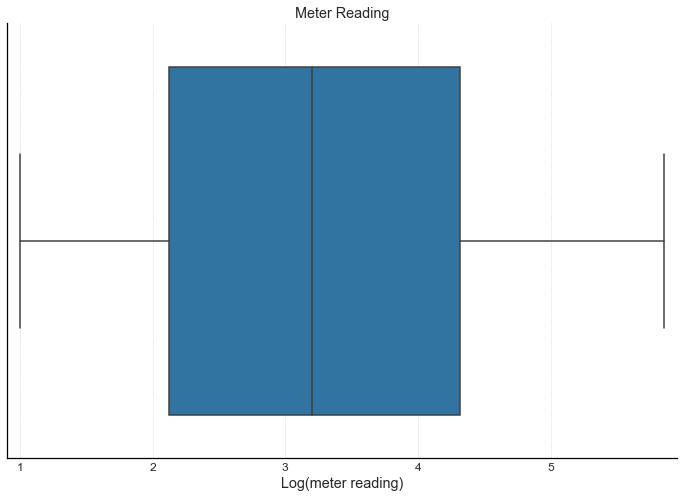

In [69]:
q = np.log1p(all_df['meter_reading'].quantile(0.8))
q10 = all_df['meter_reading'].quantile(0.05)

meter_ = all_df['meter_reading'][(all_df['meter_reading'] < q) & (all_df['meter_reading'] > 1)]
print('New shape:', meter_.shape)
sns.boxplot(meter_)
plt.title('Meter Reading')
plt.xlabel('Log(meter reading)')
plt.show()

## Electric Meter Reading 0

In [59]:
# number of buildings with electric meter reading of zero
m_id = 0
get_meter_subset(m_id)[get_meter_subset(m_id)['meter_reading'] == 0].building_id.nunique()

692

In [60]:
# months with 0 electric meter reading
get_meter_subset(m_id)[get_meter_subset(m_id)['meter_reading'] == 0].month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

There are 692 buildings which have electric meter (meter 0) readings of zero. What caused it? Blackout? Broken meter? Human error?

In [62]:
# number of sites with 0 electric meter reading
get_meter_subset(m_id)[get_meter_subset(m_id)['meter_reading'] == 0].site_id.nunique()

15

In [64]:
# types of buildings with 0 electric meter reading
get_meter_subset(m_id)[get_meter_subset(m_id)['meter_reading'] == 0].primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Religious worship', 'Warehouse/storage', 'Public services',
       'Food sales and service', 'Healthcare', 'Manufacturing/industrial',
       'Services', 'Technology/science'], dtype=object)

## Distribution: 
#### Meter Reading For Each Site

In [61]:
# get_site(5)['air_temperature'].plot.hist(bins=35)
# get_site(5)['air_temperature'][:50]

In [63]:
# PLOT: Site 0-15, Meter Reading
def hist_subplots(column, func=None):
    """
    Make histogram subplots of given column for each `site_id` (0-15).
    
    Params:
    -------
        column: str
            Name of column.
        func: callable
            Function which can be used to manipulate data.
            Example: np.log1p, np.exp, np.sqrt
    Returns:
    --------
        None
        Outputs histogram subplots for `column`
    """
    # define figure and axes
    fig, ax = plt.subplots(8,2, figsize=(12,20), dpi=70)
    
    # compute number of bins
    n_bins = np.int32(np.sqrt(get_site(0)[column].shape[0]) / 30)
    
    # iterate over each site_id
    for i in np.arange(16):
        # extract given variable at given site
        site_meter_reading = get_site(i)[column].values
        if func != None:
            site_meter_reading = func(site_meter_reading)
        # plot histogram
        ax[i%8, i//8].hist(site_meter_reading, bins=n_bins, density=True)
        ax[i%8, i//8].set_title(f'Site {i}')
        ax[i%8, i//8].set_ylabel('Freq')
        ax[i%8, i//8].set_xlabel(f'{column}')
        fig.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

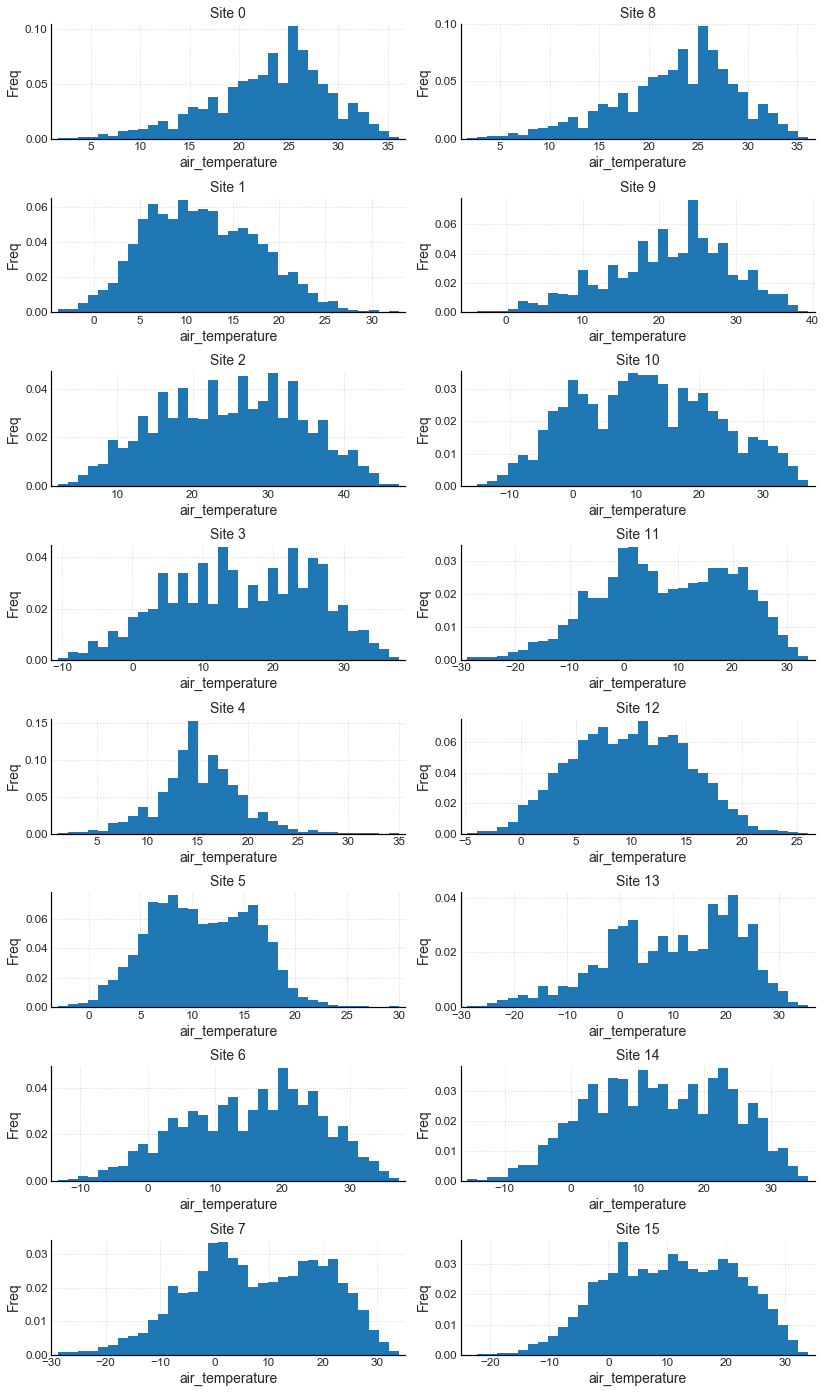

In [64]:
hist_subplots('air_temperature')

In [1]:
# hist_subplots('meter_reading', func=np.log1p)

# Which type of buildings consume the most energy?

In [68]:
bldg_type_meter = df_no1099.groupby(['primary_use',])['meter_reading'].median().sort_values()
bldg_type_meter

primary_use
Religious worship                 4.0816
Other                            12.5000
Warehouse/storage                21.2705
Retail                           25.0236
Parking                          30.3500
Entertainment/public assembly    45.4200
Public services                  45.8900
Lodging/residential              62.0182
Office                           72.0545
Manufacturing/industrial         93.8000
Services                         95.0000
Technology/science               97.0000
Food sales and service           97.2000
Education                       103.7000
Utility                         175.9535
Healthcare                      212.0000
Name: meter_reading, dtype: float64

In [69]:
# pd.DataFrame(bldg_type_meter)

In [70]:
all_df['kwh_per_sqft'] = all_df['meter_reading'] / all_df['square_feet']
all_df['kwh_per_month'] = all_df['meter_reading'] / all_df['month']

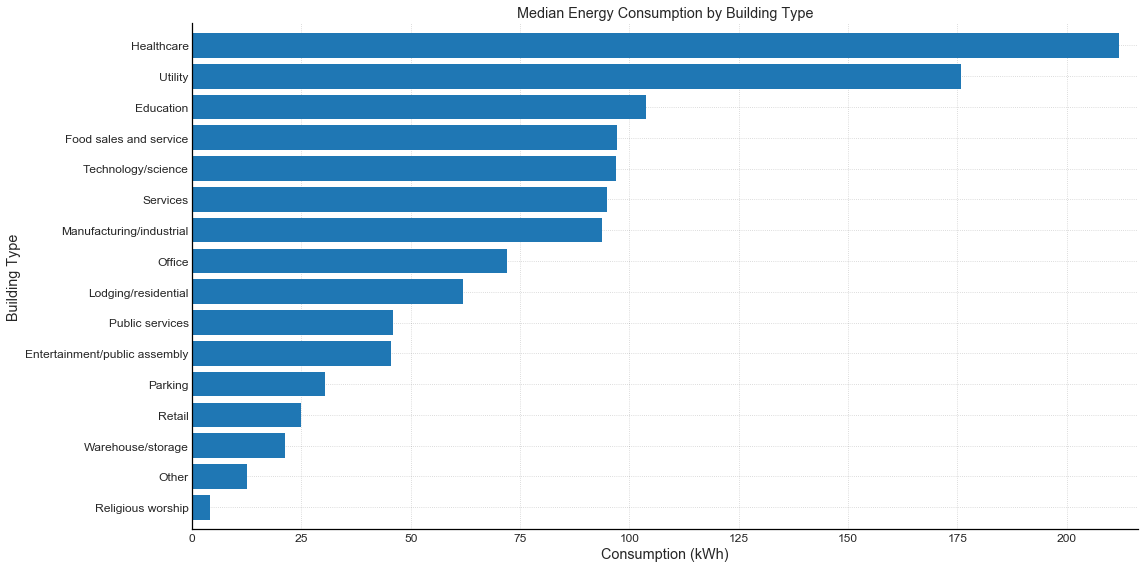

In [71]:
# PLOT: energy consumption by each type of building
barh_plot(
    y = bldg_type_meter.index,
    x = bldg_type_meter.values,
    title = 'Median Energy Consumption by Building Type',
    y_label = 'Building Type',
    x_label = 'Consumption (kWh)'
)